In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [4]:
def load_titanic_data():
  tarball_path = Path("datasets/titanic.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://homl.info/titanic.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv"))


In [5]:
train_data, test_data = load_titanic_data()

In [91]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [64]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"].copy()
X_test = test_data.copy()

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


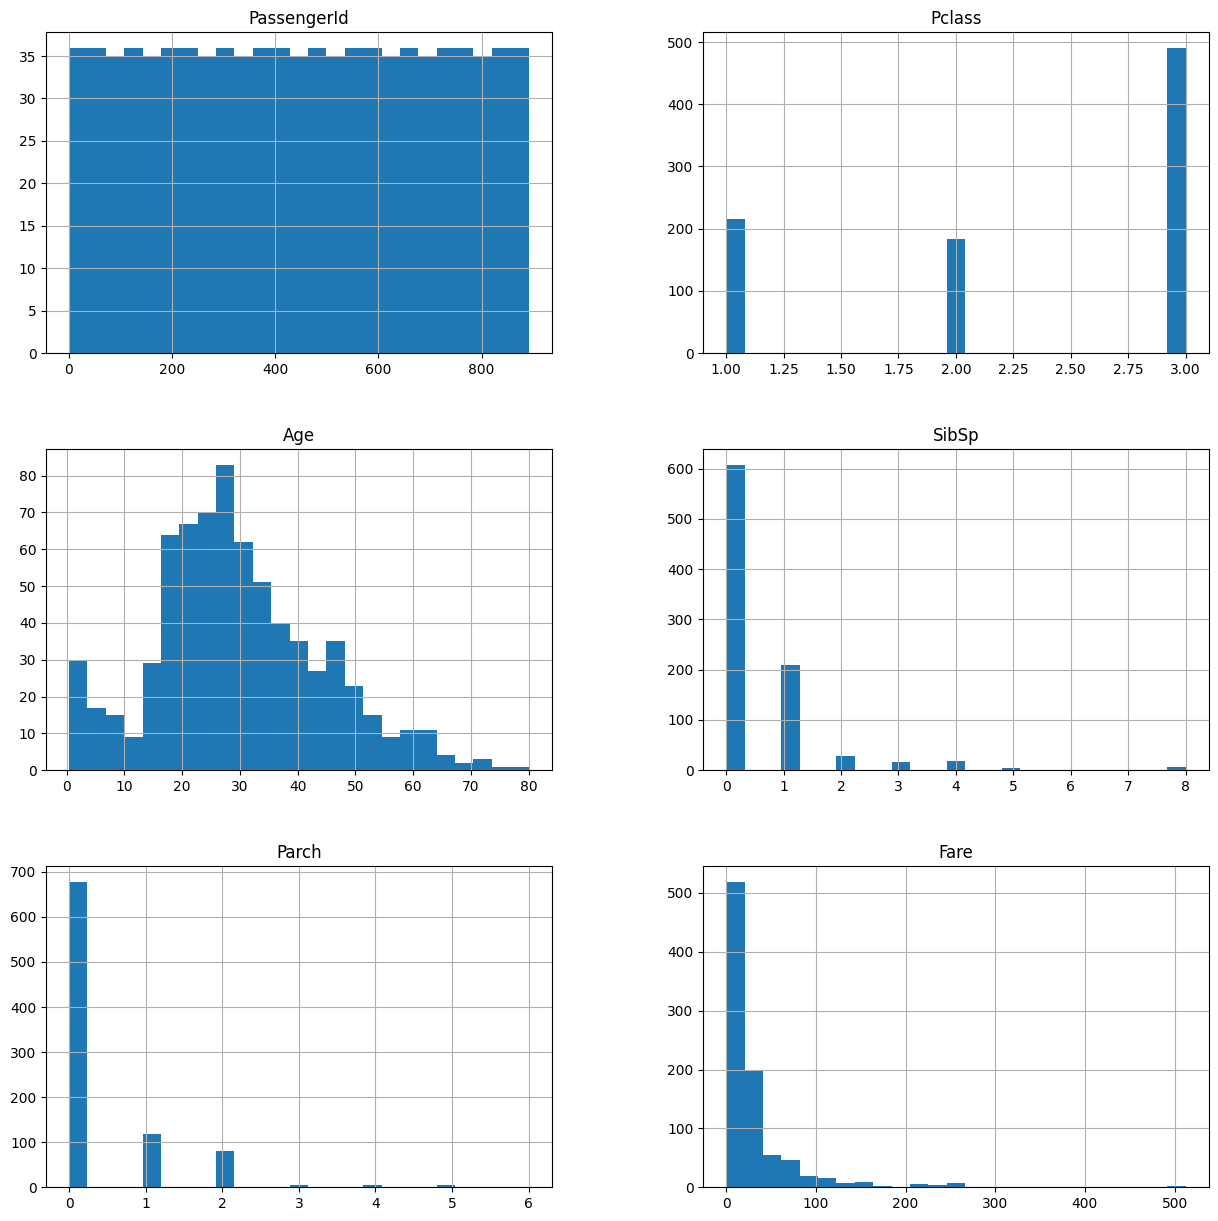

In [9]:
X_train.hist(bins=25, figsize=(15,15))
plt.show()

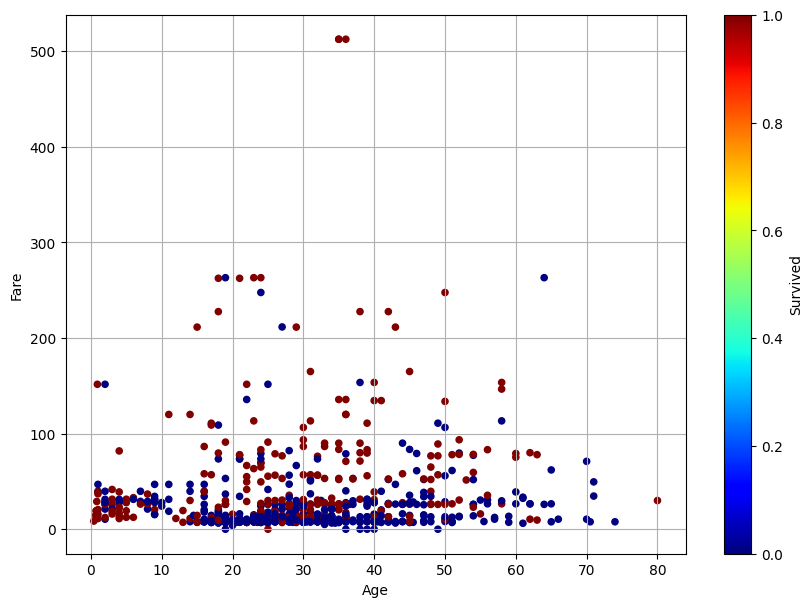

In [27]:
train_data.plot(kind="scatter",x="Age",y="Fare",
             grid=True,c="Survived",legend=True, sharex=False, figsize=(10, 7),cmap="jet")
plt.show()

In [44]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector

In [99]:
# utils function
def dropping_features(data, features_to_drop):
  return data.drop(features_to_drop, axis=1)

#transformer to create Title column from Name column
def extract_title(data):
  data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
  return data

# extracting cabin feature
def extract_cabin_features(data):
  # Extract deck letter
  data['Deck'] = data['Cabin'].str[0].fillna('Unknown')

  # Create "CabinKnown" indicator
  data['CabinKnown'] = data['Cabin'].notna().astype(int)
  return data

Clean The data

In [43]:
# handling the missing Age
age_pipeline = make_pipeline(
    KNNImputer(),
    StandardScaler()
)


Feature engineering

In [51]:

enconding_number_pipeline = make_pipeline(
  OneHotEncoder()
)

Feature selection

In [52]:
dropping_features_transformer = FunctionTransformer(dropping_features,kw_args={"features_to_drop":["Name","Ticket","Cabin"]})

In [112]:
extract_title_transformer = FunctionTransformer(extract_title)

In [113]:
extract_cabin_transformer = FunctionTransformer(extract_cabin_features)

Feature scaling

In [ ]:
standard_scaler = StandardScaler()

Making the preprocessing pipeline

In [114]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)
cat_pipeline = make_pipeline(
    extract_title_transformer,
    extract_cabin_transformer,
    dropping_features_transformer,
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
)
preprocessing = ColumnTransformer([
    ("num_enconding",enconding_number_pipeline,["Parch","SibSp","Pclass"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=num_pipeline)

Selecting model

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [115]:
logistic_rgr = Pipeline([
    ("preprocessing",preprocessing),
    ("logistic_rgr",LogisticRegression())
])
svm_clf = Pipeline([
    ("preprocessing",preprocessing),
    ("svm_clf",SVC())
])

Training model

In [116]:
logistic_rgr.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('num_enconding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Parch', 'SibSp', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(func=...
                                                                  ('functiontransformer-3',
                                                                   FunctionTransformer(func=<function dropping_features at 0x7d6b780f5990>,
                                                                                       kw_args={'features_to_drop': ['Name',
                                                                                                                     'Ticket',
                                                                                                                     'Cabin']})),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d6b78ee2c20>)])),
                ('logistic_rgr', LogisticRegression())])

In [117]:
svm_clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('num_enconding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Parch', 'SibSp', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(func=...
                                                                   FunctionTransformer(func=<function extract_cabin_features at 0x7d6b7445c700>)),
                                                                  ('functiontransformer-3',
                                                                   FunctionTransformer(func=<function dropping_features at 0x7d6b780f5990>,
                                                                                       kw_args={'features_to_drop': ['Name',
                                                                                                                     'Ticket',
                                                                                                                     'Cabin']})),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d6b78ee2c20>)])),
                ('svm_clf', SVC())])

Evaluating the different models

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_predicted_from_logistic_rgr = logistic_rgr.predict(X_train)
y_predicted_from_svm_clf = svm_clf.predict(X_train)

In [34]:
X_train["Cabin"].value_counts()

,count
Cabin,
B96 B98,4
G6,4
C23 C25 C27,4
C22 C26,3
F33,3
...,...
E34,1
C7,1
C54,1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [119]:
accuracy_logistic_rgr = accuracy_score(y_train,y_predicted_from_logistic_rgr)
accuracy_logistic_rgr

0.8395061728395061

In [120]:
precision_logistic_rgr = precision_score(y_train,y_predicted_from_logistic_rgr)
precision_logistic_rgr

0.7987987987987988

In [121]:
recall_logistic_rgr = recall_score(y_train,y_predicted_from_logistic_rgr)
recall_logistic_rgr

0.7777777777777778

In [122]:
accuracy_svm_clf = accuracy_score(y_train,y_predicted_from_svm_clf)
accuracy_svm_clf

0.8518518518518519

In [123]:
precision_svm_clf = precision_score(y_train,y_predicted_from_svm_clf)
precision_svm_clf

0.8387096774193549

In [124]:
recall_svm_clf = recall_score(y_train,y_predicted_from_svm_clf)
recall_svm_clf

0.7602339181286549